In [1]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import current_date
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from datetime import date
import plotly.graph_objects as go
from dateutil.relativedelta import relativedelta

%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

## Initializing Spark Content

In [2]:
# start the session
conf = SparkConf().setAppName('*')
conf.set('spark.driver.cores', '5')
conf.set('spark.driver.memory', '30G')
conf.set('spark.driver.maxResultSize', '5G')
conf.set('spark.executor.cores', '5')
conf.set('spark.executor.instances', '20')
conf.set('spark.executor.memory', '30G')
conf.set('spark.executor.memoryOverhead', '2G')
conf.set('spark.kryoserializer.buffer.max', '2047')
conf.set('spark.locality.wait', '0')
conf.set('spark.port.maxRetries', '128')
conf.set('spark.scheduler.minRegisteredResourcesRatio', '1')
conf.set('spark.network.timeout', '500')
conf.set('spark.dynamicAllocation.enabled', 'False')
conf.set('spark.shuffle.service.enabled', 'False')
conf.set('spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation', 'True')
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

## Data Collection 

In [ ]:
df= spark.sql("""


with base as (
SELECT A.atoll_site_id,
       MIN(A.date_time) as min_date,
       data_traffic

FROM

(SELECT atoll_site_id,
       date_time,
       SUM(ps_vols_mbytes_dl_plmn + ps_vols_mbytes_ul_plmn) AS data_traffic
FROM prod_helix.npm_rpt_gen_cell_plmn_traffic_mo
WHERE techchar = '5'
GROUP BY atoll_site_id, date_time ) A


WHERE A.data_traffic > 0

GROUP BY A.atoll_site_id, A.data_traffic
),

base_a as (
select atoll_site_id, avg(data_traffic) as data_traffic from base
group by atoll_site_id
),

base_b as (
Select atoll_site_id, min(min_date) as min_date
from base
group by atoll_site_id
), 

base_final as (

SELECT base_a.atoll_site_id, base_b.min_date, base_a.data_traffic
FROM base_a
INNER JOIN 
base_b
On 
base_a.atoll_site_id=base_b.atoll_site_id 
),

base_2 as (
SELECT name, latitude, longitude, region, pylon_height, base_final.data_traffic, base_final.min_date
FROM prod_atoll.atoll_sites_new as t1
INNER JOIN 
base_final
ON 
t1.name=base_final.atoll_site_id
), 

t1 as (

SELECT name, latitude, longitude, region, pylon_height,structure, hcs_indicator, substr(cast(min_date AS string),1,7) as min_date, data_traffic
FROM prod_ds_sc_ane_feature_stores.live_site_type_profile as t2
LEFT JOIN 
base_2
ON 
base_2.name=t2.atoll_site_id
),

t2 as (

SELECT atoll_site_id, avg(lte_util) as lte_avg,avg(cell_thruput_mbps_dl) as thruput_avg, substr(cast(date_time AS string),1,7) as partition_data_date, avg(max_ngbr_activ_data_users_dl) as avg_ngbr, avg(prbs_used_by_pdsch) as avg_prbs, avg(avail_prbs_dl) as avg_avail_prbs, avg(ngbr_activ_data_thrpt_mbps_dl) as avg_ngbr_thrpt, avg(cell_datavol_mb_dl) as avg_datavol,
avg(cell_activity_time_s_dl) as avg_activity, avg(non_ca_user_thruput_mbps_dl) as avg_non_ca, avg(ca_user_thruput_mbps_dl) as avg_ca, avg(cell_ca_traf_vol_dl_mb) as avg_ca_traf, avg(cell_volte_datavol_mb_dl) as avg_volte, avg(cell_volte_sessiontime_erl_dl) avg_volte_session
FROM prod_helix.npm_rpt_vf_kpi160_v3onwrds_cell_dy
GROUP BY atoll_site_id,  substr(cast(date_time AS string),1,7)
), 

 con_1 as (
SELECT name, latitude, longitude, region, pylon_height,structure, hcs_indicator, min_date, data_traffic as 5g_data_traffic, lte_avg,thruput_avg, partition_data_date, avg_ngbr_thrpt,avg_prbs,avg_avail_prbs,avg_ngbr,avg_datavol, avg_activity, avg_non_ca, avg_ca, avg_ca_traf,avg_volte,avg_volte_session
FROM t1
INNER JOIN t2 
ON t1.name=t2.atoll_site_id
GROUP BY 
 name, latitude, longitude, region, pylon_height,structure, hcs_indicator, min_date, data_traffic, lte_avg, partition_data_date, thruput_avg, avg_ngbr_thrpt,avg_prbs,avg_avail_prbs,avg_ngbr,avg_datavol, avg_activity, avg_non_ca, avg_ca, avg_ca_traf,avg_volte,avg_volte_session
 ORDER BY 
 name
) , 

4g_traffic as (
SELECT atoll_site_id,
       substr(cast(date_time AS string),1,7) as partition_data_date,
       SUM(ps_vols_mbytes_dl_plmn + ps_vols_mbytes_ul_plmn) AS 4g_data_traffic
FROM prod_helix.npm_rpt_gen_cell_plmn_traffic_mo
WHERE techchar = '4'
GROUP BY atoll_site_id, date_time
) , 

con_2 as (
SELECT name, latitude, longitude, region, pylon_height,structure, hcs_indicator, min_date, 5g_data_traffic, lte_avg, thruput_avg, 4g_data_traffic,con_1.partition_data_date, avg_ngbr_thrpt,avg_prbs,avg_avail_prbs,avg_ngbr,avg_datavol, avg_activity, avg_non_ca, avg_ca, avg_ca_traf,avg_volte,avg_volte_session
from con_1 
inner join
4g_traffic
on con_1.name=4g_traffic.atoll_site_id 
and 
con_1.partition_data_date=4g_traffic.partition_data_date
), 
 con_3 as (
 SELECT atoll_site_id, rev_ps_4g, rev_cs_4g, rev_all, substr(cast(partition_data_timestamp AS string),1,7) as partition_data_date
FROM prod_ds_sc_revenue_allocation_feature_stores.site_summary_monthly_history
UNION 
SELECT atoll_site_id, rev_ps_4g, rev_cs_4g, rev_all, substr(cast(partition_data_timestamp AS string),1,7) as partition_data_date
FROM prod_ds_sc_revenue_allocation_feature_stores.site_summary_monthly_v20221115_history
 ), 
 
 con_4 as (
 SELECT name, latitude, longitude, region, pylon_height,structure, hcs_indicator, min_date, 5g_data_traffic, lte_avg, thruput_avg, 4g_data_traffic, rev_ps_4g, rev_cs_4g, rev_all,con_2.partition_data_date , avg_ngbr_thrpt,avg_prbs,avg_avail_prbs,avg_ngbr,avg_datavol, avg_activity, avg_non_ca, avg_ca, avg_ca_traf,avg_volte,avg_volte_session
 from 
 con_2 
 inner join 
 con_3 
 on 
 con_2.name=con_3.atoll_site_id
 and 
 con_2.partition_data_date= con_3.partition_data_date
 ),

ranked_data AS (
  SELECT
    name,
    latitude,
    longitude,
    region,
    pylon_height,
    structure,
    hcs_indicator,
   min_date,
    `5g_data_traffic`,
    lte_avg,
    thruput_avg,
    `4g_data_traffic`,
     partition_data_date, avg_ngbr_thrpt,avg_prbs,avg_avail_prbs,avg_ngbr,avg_datavol, avg_activity, avg_non_ca, avg_ca, avg_ca_traf,avg_volte,avg_volte_session
  FROM
    con_4
), 

f as (

SELECT
  name as atoll_site_id,
  latitude,
  longitude,
  region,
  structure,
  hcs_indicator,
  min_date,
  5g_data_traffic, 
  lte_avg,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session, partition_data_date,thruput_avg, 4g_data_traffic
FROM
  ranked_data
 where
 partition_data_date > min_date
 
GROUP BY
  name, latitude, longitude, region, structure, hcs_indicator, min_date, `5g_data_traffic`, partition_data_date, lte_avg,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session,thruput_avg, 4g_data_traffic
ORDER BY
  name, partition_data_date desc
), 

data_drop as (SELECT
        date_time AS partition_data_timestamp,
        atoll_site_id,
        '4G' AS technology_type,
        COUNT(DISTINCT CELL_NAME) AS count_cells,
        SUM(erab_rel_abn) AS total_session_drop,
        (SUM(trafvol_pdcp_sdu_dl_mbytes) + SUM(trafvol_pdcp_sdu_ul_mbytes)) AS total_data_volume_mb,
        CASE
            WHEN (SUM(trafvol_pdcp_sdu_dl_mbytes) + SUM(trafvol_pdcp_sdu_ul_mbytes)) > 0 THEN CAST(SUM(erab_rel_abn) / NULLIF((SUM(trafvol_pdcp_sdu_dl_mbytes) + SUM(trafvol_pdcp_sdu_ul_mbytes)), 0) AS DECIMAL(38,9))
            ELSE NULL
        END AS session_drop_per_mb,
        CASE
            WHEN SUM(erab_rel_all) > 0 THEN CAST(SUM(erab_rel_abn) / NULLIF(SUM(erab_rel_all), 0) * 100 AS DECIMAL(38,9))
            ELSE NULL
        END AS session_drop_percentage
    FROM prod_helix.npm_rpt_v_gen_cell_ran4g_dy
    group by atoll_site_id, partition_data_timestamp
  ), 
  
  data_drop_2 as(
  SELECT 
  atoll_site_id, avg(count_cells) as avg_cells, avg(total_session_drop) as avg_total_session_drop, avg(total_data_volume_mb) as avg_total_data_volume_mb,avg(session_drop_per_mb) as avg_session_drop_per_mb, avg(session_drop_percentage) as avg_session_drop_percentage,substr(cast(partition_data_timestamp AS string),1,7) as partition_data_timestamp
  FROM data_drop
  group by atoll_site_id, substr(cast(partition_data_timestamp AS string),1,7) 
  ),
  
  network as (SELECT
        date_time AS partition_data_timestamp,
        atoll_site_id,
        '4G' AS technology_type,
        COUNT(DISTINCT CELL_NAME) AS count_cells,
        CAST(SUM(CELL_AVAILABILITY_S) AS DECIMAL(38, 10)) AS sum_cell_availability_seconds,
        COUNT(DISTINCT CELL_NAME) * 86400 AS sum_max_available_seconds,
        CASE
            WHEN COUNT(DISTINCT CELL_NAME) * 86400 > 0 THEN (CAST(SUM(CELL_AVAILABILITY_S) AS DECIMAL(38, 10)) / NULLIF((COUNT(DISTINCT CELL_NAME) * 86400), 0)) * 100
            ELSE NULL
        END AS cell_availability_percentage
    FROM prod_helix.npm_rpt_v_gen_cell_ran4g_dy
    group by atoll_site_id, partition_data_timestamp
  ),
  
  network_2 as (
  
  SELECT 
  atoll_site_id, avg(sum_cell_availability_seconds) as avg_csum_cell_availability_seconds, avg(sum_max_available_seconds) as avg_sum_max_available_seconds, avg(cell_availability_percentage) as avg_cell_availability_percentage,substr(cast(partition_data_timestamp AS string),1,7) as partition_data_timestamp
  FROM network
  group by atoll_site_id, substr(cast(partition_data_timestamp AS string),1,7) 
  ),
  
  call_drop as (
  SELECT
        date_time AS partition_data_timestamp,
        atoll_site_id,
        '4G' AS technology_type,
        COUNT(DISTINCT CELL_NAME) AS count_cells,
        SUM(NED_V5R_VOLTE_CALLS) AS total_calls,
        SUM(ned_t1_erlangs_voice) AS total_erlang_voice,
        SUM(NED_V5R_DROPPED_VOLTE_CALLS) AS total_drop_calls,
        CASE
            WHEN SUM(NED_V5R_VOLTE_CALLS) > 0 THEN (SUM(NED_V5R_DROPPED_VOLTE_CALLS) / NULLIF(SUM(NED_V5R_VOLTE_CALLS), 0)) * 100
            ELSE NULL
        END AS drops_all_calls_percentage,
        CASE
            WHEN SUM(ned_t1_erlangs_voice) > 0 THEN CAST((SUM(NED_V5R_DROPPED_VOLTE_CALLS) / SUM(ned_t1_erlangs_voice)) AS DECIMAL(38, 10))
            ELSE NULL
        END AS voice_call_drops_per_erlang
    FROM prod_helix.npm_rpt_v_gen_cell_ran4g_dy
    group by atoll_site_id, partition_data_timestamp
  ), 
  
  call_drop_2 as (
  SELECT 
  atoll_site_id, avg(total_calls) as avg_total_calls, avg(total_erlang_voice) as avg_total_erlang_voice, avg(total_drop_calls) as avg_total_drop_calls, avg(drops_all_calls_percentage) as avg_drops_all_calls_percentage, avg(voice_call_drops_per_erlang) as avg_voice_call_drops_per_erlang, substr(cast(partition_data_timestamp AS string),1,7) as partition_data_timestamp, avg(count_cells) as avg_count_cells
  FROM call_drop
  group by atoll_site_id, substr(cast(partition_data_timestamp AS string),1,7) 
  ),

fannie as (
SELECT f.atoll_site_id, f.region,f.structure, f.hcs_indicator, f.min_date, f.`5g_data_traffic`, lte_avg,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session, call_drop_2.avg_drops_all_calls_percentage, call_drop_2.avg_total_calls, call_drop_2.avg_total_drop_calls, call_drop_2.avg_total_erlang_voice, call_drop_2.avg_voice_call_drops_per_erlang, 
network_2.avg_cell_availability_percentage, network_2.avg_csum_cell_availability_seconds, network_2.avg_sum_max_available_seconds,data_drop_2.avg_cells, data_drop_2.avg_session_drop_per_mb, data_drop_2.avg_session_drop_percentage, data_drop_2.avg_total_data_volume_mb, data_drop_2.avg_total_session_drop, f.partition_data_date, call_drop_2.avg_count_cells,thruput_avg, 4g_data_traffic
FROM f inner join call_drop_2 on f.atoll_site_id=call_drop_2.atoll_site_id and f.partition_data_date=call_drop_2.partition_data_timestamp
inner join network_2 on f.atoll_site_id=network_2.atoll_site_id and f.partition_data_date=network_2.partition_data_timestamp
inner join data_drop_2 on f.atoll_site_id=data_drop_2.atoll_site_id and f.partition_data_date=data_drop_2.partition_data_timestamp
),

f_2 as (
SELECT *, row_number() OVER (partition by atoll_site_id ORDER BY partition_data_date DESC) AS row_num
from fannie
) , 

kg as (
SELECT * from f_2
where row_num < 4
order by atoll_site_id,row_num asc
) 

SELECT atoll_site_id,region,structure,hcs_indicator,min_date,5g_data_traffic,avg(lte_avg) as avg_lte, avg(avg_prbs) as avg_prbs,  avg(avg_avail_prbs) as avg_avail_prbs, avg(avg_ngbr) as avg_ngbr, avg(avg_volte) as avg_volte, avg(avg_volte_session) as avg_volte_session, avg(avg_drops_all_calls_percentage) as avg_drops_all_calls_percentage, avg(avg_total_calls) as avg_total_calls,
avg(avg_total_drop_calls) as avg_total_drop_calls, avg(avg_total_erlang_voice) as avg_total_erlang_voice, avg(avg_voice_call_drops_per_erlang) as avg_voice_call_drops_per_erlang, avg(avg_cell_availability_percentage) as avg_cell_availability_percentage,
avg(avg_csum_cell_availability_seconds) as avg_csum_cell_availability_seconds,avg(avg_sum_max_available_seconds) as avg_sum_max_available_seconds, avg(avg_session_drop_per_mb) as avg_session_drop_per_mb, avg(avg_session_drop_percentage) as avg_session_drop_percentage, avg(avg_total_data_volume_mb) as avg_total_data_volume_mb, avg(avg_total_session_drop) as avg_total_session_drop,avg(avg_count_cells) as avg_avg_count_cells, avg(thruput_avg) as avg_thruput, avg(4g_data_traffic) as avg_4g_data_traffic

from kg 
group by atoll_site_id,region,structure,hcs_indicator,min_date,5g_data_traffic

   
                     """).toPandas()

In [48]:
import pickle
df.to_pickle("5g_2024.pkl")

In [3]:
import pickle
df = pd.read_pickle("5g_2024.pkl") 

In [4]:
df.head()

,atoll_site_id,region,structure,hcs_indicator,min_date,5g_data_traffic,avg_lte,avg_prbs,avg_avail_prbs,avg_ngbr,...,avg_cell_availability_percentage,avg_csum_cell_availability_seconds,avg_sum_max_available_seconds,avg_session_drop_per_mb,avg_session_drop_percentage,avg_total_data_volume_mb,avg_total_session_drop,avg_avg_count_cells,avg_thruput,avg_4g_data_traffic
0,KZN_30541,KZN,Monopole,Outdoor,2022-12,1859652.3522693640000,60.921170484600000000,22.184732807300000000,37.222700119466670000,2.698878205900000000,...,92.60930466670000,720129.955060319300000000,7.776000e+05,0.01205603966670000,0.44300061266670000,214900.31830773566670000,2566.555555555566670000,9.000000,5.973873224200000000,15190772.0740233330000
1,KZN_30551,KZN,Monopole,Outdoor,2021-09,703229.1034628460000,28.452692448900000000,11.769903360066670000,45.666666666700000000,3.557224890300000000,...,100.51514633330000,781605.778307806500000000,7.776000e+05,0.00516967100000000,0.11964784966670000,138538.75821861500000000,681.905017921166670000,9.000000,10.477647416366670000,8617554.9514456670000
2,NGA_18761,NGA,Monopole,Outdoor,2023-03,474670.5454990000000,56.766965536533330000,29.934487380100000000,48.922111422833330000,3.881601761133330000,...,95.36217133330000,895189.339861751133330000,9.392516e+05,0.00011562233330000,0.01282834866670000,437232.92465976766670000,47.832744495666670000,10.870968,13.065869095333330000,11301431.1740313330000
3,NGA_20781,NGA,Monopole,Outdoor,2022-07,1637384.2502103750000,31.591847425066670000,14.048151446733330000,41.014584105800000000,3.086845880366670000,...,99.99909433330000,777592.956989247300000000,7.776000e+05,0.00003924466670000,0.00325598533330000,237924.62957679666670000,9.094265232966670000,9.000000,15.917387291866670000,17905758.0218540000000
4,KZN_34821,KZN,Monopole,Outdoor,2022-08,1484324.3950609330000,65.300042001933330000,28.291273581600000000,43.698347107433330000,3.357364823000000000,...,87.16788366670000,893634.593607275700000000,1.025652e+06,0.00231754166670000,0.11183411200000000,626150.52547939266670000,1451.865406006666670000,11.870968,12.958015115266670000,33053096.9766356670000


In [5]:
row_count=len(df)
print(row_count)

2009


In [5]:
df.isnull().sum()

atoll_site_id                         0
region                                0
structure                             0
hcs_indicator                         0
min_date                              0
5g_data_traffic                       0
avg_lte                               0
avg_prbs                              0
avg_avail_prbs                        0
avg_ngbr                              0
avg_volte                             0
avg_volte_session                     0
avg_drops_all_calls_percentage        0
avg_total_calls                       0
avg_total_drop_calls                  0
avg_total_erlang_voice                0
avg_voice_call_drops_per_erlang       0
avg_cell_availability_percentage      0
avg_csum_cell_availability_seconds    0
avg_sum_max_available_seconds         0
avg_session_drop_per_mb               0
avg_session_drop_percentage           0
avg_total_data_volume_mb              0
avg_total_session_drop                0
avg_avg_count_cells                   0


## DATA CLEANING

In [6]:
has_nan = df.isna().any().any()

if has_nan:
    print("DataFrame has NaN values.")
else:
    print("DataFrame does not have NaN values.")

DataFrame does not have NaN values.


In [7]:
columns_to_drop = [ 'atoll_site_id','min_date','structure','region','hcs_indicator']
df = df.drop(columns=columns_to_drop, axis=1)

In [8]:
df.head()

,5g_data_traffic,avg_lte,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session,avg_drops_all_calls_percentage,avg_total_calls,avg_total_drop_calls,...,avg_cell_availability_percentage,avg_csum_cell_availability_seconds,avg_sum_max_available_seconds,avg_session_drop_per_mb,avg_session_drop_percentage,avg_total_data_volume_mb,avg_total_session_drop,avg_avg_count_cells,avg_thruput,avg_4g_data_traffic
0,1859652.3522693640000,60.921170484600000000,22.184732807300000000,37.222700119466670000,2.698878205900000000,0.036857814666670000,1.559453736900000000,0.25380633330000,4721.883908045966670000,12.052873563233330000,...,92.60930466670000,720129.955060319300000000,7.776000e+05,0.01205603966670000,0.44300061266670000,214900.31830773566670000,2566.555555555566670000,9.000000,5.973873224200000000,15190772.0740233330000
1,703229.1034628460000,28.452692448900000000,11.769903360066670000,45.666666666700000000,3.557224890300000000,0E-18,0.629451756000000000,0.05807500000000,3497.689247311800000000,2.081003584233330000,...,100.51514633330000,781605.778307806500000000,7.776000e+05,0.00516967100000000,0.11964784966670000,138538.75821861500000000,681.905017921166670000,9.000000,10.477647416366670000,8617554.9514456670000
2,474670.5454990000000,56.766965536533330000,29.934487380100000000,48.922111422833330000,3.881601761133330000,59337238.286255940200000000,1.513510947100000000,0.10358133330000,5956.806246799800000000,6.163031234000000000,...,95.36217133330000,895189.339861751133330000,9.392516e+05,0.00011562233330000,0.01282834866670000,437232.92465976766670000,47.832744495666670000,10.870968,13.065869095333330000,11301431.1740313330000
3,1637384.2502103750000,31.591847425066670000,14.048151446733330000,41.014584105800000000,3.086845880366670000,43446043.361803924800000000,1.040332731833330000,0.05548233330000,4802.762007168466670000,2.822580645166670000,...,99.99909433330000,777592.956989247300000000,7.776000e+05,0.00003924466670000,0.00325598533330000,237924.62957679666670000,9.094265232966670000,9.000000,15.917387291866670000,17905758.0218540000000
4,1484324.3950609330000,65.300042001933330000,28.291273581600000000,43.698347107433330000,3.357364823000000000,0.094025767466670000,0.831325848500000000,0.08343866670000,4995.089358546533330000,4.225064886933330000,...,87.16788366670000,893634.593607275700000000,1.025652e+06,0.00231754166670000,0.11183411200000000,626150.52547939266670000,1451.865406006666670000,11.870968,12.958015115266670000,33053096.9766356670000


In [9]:
df.head()

,5g_data_traffic,avg_lte,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session,avg_drops_all_calls_percentage,avg_total_calls,avg_total_drop_calls,...,avg_cell_availability_percentage,avg_csum_cell_availability_seconds,avg_sum_max_available_seconds,avg_session_drop_per_mb,avg_session_drop_percentage,avg_total_data_volume_mb,avg_total_session_drop,avg_avg_count_cells,avg_thruput,avg_4g_data_traffic
0,1859652.3522693640000,60.921170484600000000,22.184732807300000000,37.222700119466670000,2.698878205900000000,0.036857814666670000,1.559453736900000000,0.25380633330000,4721.883908045966670000,12.052873563233330000,...,92.60930466670000,720129.955060319300000000,7.776000e+05,0.01205603966670000,0.44300061266670000,214900.31830773566670000,2566.555555555566670000,9.000000,5.973873224200000000,15190772.0740233330000
1,703229.1034628460000,28.452692448900000000,11.769903360066670000,45.666666666700000000,3.557224890300000000,0E-18,0.629451756000000000,0.05807500000000,3497.689247311800000000,2.081003584233330000,...,100.51514633330000,781605.778307806500000000,7.776000e+05,0.00516967100000000,0.11964784966670000,138538.75821861500000000,681.905017921166670000,9.000000,10.477647416366670000,8617554.9514456670000
2,474670.5454990000000,56.766965536533330000,29.934487380100000000,48.922111422833330000,3.881601761133330000,59337238.286255940200000000,1.513510947100000000,0.10358133330000,5956.806246799800000000,6.163031234000000000,...,95.36217133330000,895189.339861751133330000,9.392516e+05,0.00011562233330000,0.01282834866670000,437232.92465976766670000,47.832744495666670000,10.870968,13.065869095333330000,11301431.1740313330000
3,1637384.2502103750000,31.591847425066670000,14.048151446733330000,41.014584105800000000,3.086845880366670000,43446043.361803924800000000,1.040332731833330000,0.05548233330000,4802.762007168466670000,2.822580645166670000,...,99.99909433330000,777592.956989247300000000,7.776000e+05,0.00003924466670000,0.00325598533330000,237924.62957679666670000,9.094265232966670000,9.000000,15.917387291866670000,17905758.0218540000000
4,1484324.3950609330000,65.300042001933330000,28.291273581600000000,43.698347107433330000,3.357364823000000000,0.094025767466670000,0.831325848500000000,0.08343866670000,4995.089358546533330000,4.225064886933330000,...,87.16788366670000,893634.593607275700000000,1.025652e+06,0.00231754166670000,0.11183411200000000,626150.52547939266670000,1451.865406006666670000,11.870968,12.958015115266670000,33053096.9766356670000


In [9]:
np.random.seed(100)

random_rows=df.sample(n=100)

df=df[~df.index.isin(random_rows.index)]

In [10]:
random_rows.head()

,5g_data_traffic,avg_lte,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session,avg_drops_all_calls_percentage,avg_total_calls,avg_total_drop_calls,...,avg_cell_availability_percentage,avg_csum_cell_availability_seconds,avg_sum_max_available_seconds,avg_session_drop_per_mb,avg_session_drop_percentage,avg_total_data_volume_mb,avg_total_session_drop,avg_avg_count_cells,avg_thruput,avg_4g_data_traffic
1916,2743920.3659950000000,11.531578747733330000,5.270943098733330000,45.474910394266670000,3.541884329333330000,0.012891586700000000,0.373780672766670000,0.16197800000000,1868.286507936533330000,1.948873527933330000,...,84.67055833330000,877864.349146883300000000,1.036800e+06,0.00347122866670000,0.07819124700000000,75102.51979588600000000,236.643958013300000000,12.000000,8.778930191400000000,2220831.0738586670000
785,593519.9042678000000,31.483751443866670000,16.808639546000000000,49.522491039400000000,3.948354610766670000,11057484.227479092000000000,0.271779433033330000,0.07882266670000,2320.210344827600000000,1.734482758633330000,...,98.42240600000000,1020443.507662835233330000,1.036800e+06,0.00003254533330000,0.00403413800000000,271851.88642696066670000,8.813409961666670000,12.000000,14.362884303466670000,8431845.1784543330000
75,1038834.0253392860000,30.873452874866670000,15.436726437433330000,50.000000000000000000,3.981961780166670000,44960124.659438470733330000,1.202547988133330000,0.03353600000000,4169.484229390666670000,1.376702508933330000,...,101.80509500000000,527757.611111111100000000,5.184000e+05,0.00003308400000000,0.00234261633330000,210784.66803745300000000,6.850896057366670000,6.000000,22.476866479000000000,14307101.5894710000000
1694,533646.1729986670000,48.961408942000000000,19.360052606433330000,36.007805325966670000,2.566328534066670000,1.318708447733330000,2.296799900500000000,0.15071533330000,10297.867895545333330000,16.490783410133330000,...,84.33031400000000,786617.641676469833330000,9.392516e+05,0.00824734533330000,0.31732235033330000,283359.63331274833330000,2173.991167434733330000,10.870968,6.597970236866670000,6449364.1234153330000
650,1211286.0848336670000,61.321605809833330000,26.393596278866670000,42.236467236500000000,3.212073721000000000,0.015132438433330000,0.771533508966670000,0.05934400000000,6257.713409961666670000,3.873822766033330000,...,91.83526400000000,772815.282246307133330000,8.409600e+05,0.00118654800000000,0.06601211366670000,577259.66733717566670000,679.056890372033330000,9.733333,13.194635529766670000,26805518.3178736670000


In [11]:
df.head()

,5g_data_traffic,avg_lte,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session,avg_drops_all_calls_percentage,avg_total_calls,avg_total_drop_calls,...,avg_cell_availability_percentage,avg_csum_cell_availability_seconds,avg_sum_max_available_seconds,avg_session_drop_per_mb,avg_session_drop_percentage,avg_total_data_volume_mb,avg_total_session_drop,avg_avg_count_cells,avg_thruput,avg_4g_data_traffic
0,1859652.3522693640000,60.921170484600000000,22.184732807300000000,37.222700119466670000,2.698878205900000000,0.036857814666670000,1.559453736900000000,0.25380633330000,4721.883908045966670000,12.052873563233330000,...,92.60930466670000,720129.955060319300000000,7.776000e+05,0.01205603966670000,0.44300061266670000,214900.31830773566670000,2566.555555555566670000,9.000000,5.973873224200000000,15190772.0740233330000
1,703229.1034628460000,28.452692448900000000,11.769903360066670000,45.666666666700000000,3.557224890300000000,0E-18,0.629451756000000000,0.05807500000000,3497.689247311800000000,2.081003584233330000,...,100.51514633330000,781605.778307806500000000,7.776000e+05,0.00516967100000000,0.11964784966670000,138538.75821861500000000,681.905017921166670000,9.000000,10.477647416366670000,8617554.9514456670000
2,474670.5454990000000,56.766965536533330000,29.934487380100000000,48.922111422833330000,3.881601761133330000,59337238.286255940200000000,1.513510947100000000,0.10358133330000,5956.806246799800000000,6.163031234000000000,...,95.36217133330000,895189.339861751133330000,9.392516e+05,0.00011562233330000,0.01282834866670000,437232.92465976766670000,47.832744495666670000,10.870968,13.065869095333330000,11301431.1740313330000
3,1637384.2502103750000,31.591847425066670000,14.048151446733330000,41.014584105800000000,3.086845880366670000,43446043.361803924800000000,1.040332731833330000,0.05548233330000,4802.762007168466670000,2.822580645166670000,...,99.99909433330000,777592.956989247300000000,7.776000e+05,0.00003924466670000,0.00325598533330000,237924.62957679666670000,9.094265232966670000,9.000000,15.917387291866670000,17905758.0218540000000
4,1484324.3950609330000,65.300042001933330000,28.291273581600000000,43.698347107433330000,3.357364823000000000,0.094025767466670000,0.831325848500000000,0.08343866670000,4995.089358546533330000,4.225064886933330000,...,87.16788366670000,893634.593607275700000000,1.025652e+06,0.00231754166670000,0.11183411200000000,626150.52547939266670000,1451.865406006666670000,11.870968,12.958015115266670000,33053096.9766356670000


In [12]:
#from sklearn.mixture import GaussianMixture
#df=df[[ 'avg_lte','5g_data_traffic', 'avg_prbs', 'avg_avail_prbs', 'avg_ngbr', 'avg_volte', 'avg_volte_session', 'avg_drops_all_calls_percentage', 'avg_total_calls', 'avg_total_drop_calls', 'avg_total_erlang_voice', 'avg_voice_call_drops_per_erlang', 'avg_cell_availability_percentage', 'avg_csum_cell_availability_seconds', 'avg_sum_max_available_seconds', 'avg_session_drop_per_mb', 'avg_session_drop_percentage', 'avg_total_data_volume_mb', 'avg_total_session_drop']]
df=df.astype(float)
#noise_level=0.2
#duplicated_data=pd.concat([features]*2,ignore_index=True)[:len(features)]
#noisy=duplicated_data+np.random.normal(0,noise_level,size=duplicated_data.shape)
#df=pd.concat([features,noisy],ignore_index=True)

<IPython.core.display.Javascript object>


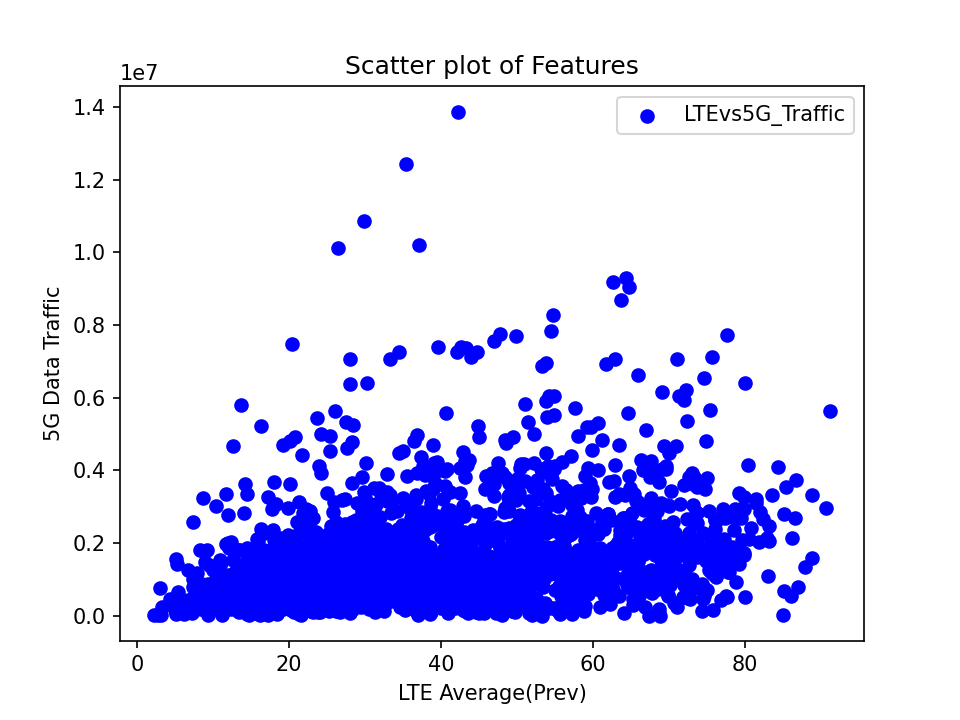

In [14]:
## Scatter Plot for Origional Dataset 
plt.scatter(df['avg_lte'],df['5g_data_traffic'], label='LTEvs5G_Traffic', color='blue')

##Scatter Plot for the Noisy Dataset 
##plt.scatter(features['avg_drops_all_calls_percentage'],features['5g_data_traffic'], label='DROP_CALLvs5G_Traffic', color='red')
            
plt.xlabel('LTE Average(Prev)')
plt.ylabel('5G Data Traffic')
plt.title('Scatter plot of Features')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


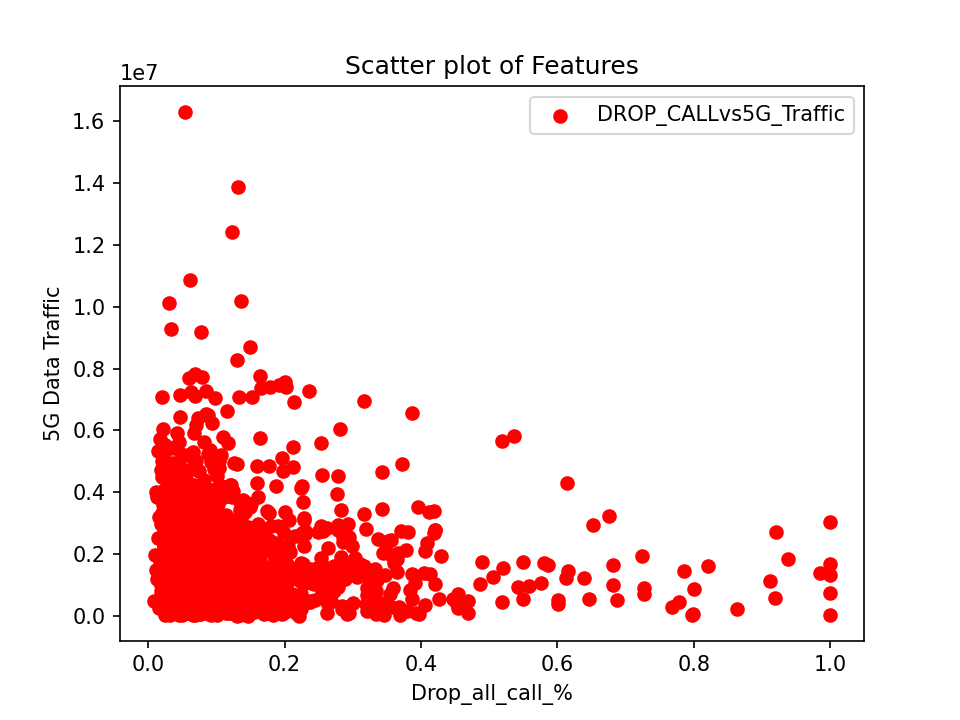

In [36]:
##Scatter Plot for the Noisy Dataset 
plt.scatter(features['avg_drops_all_calls_percentage'],features['5g_data_traffic'], label='DROP_CALLvs5G_Traffic', color='red')
            
plt.xlabel('Drop_all_call_%')
plt.ylabel('5G Data Traffic')
plt.title('Scatter plot of Features')
plt.legend()
plt.show()


In [15]:
df['avg_drops_all_calls_percentage']=df['avg_drops_all_calls_percentage'].apply(lambda x: 1 if x > 1 else x)

<IPython.core.display.Javascript object>


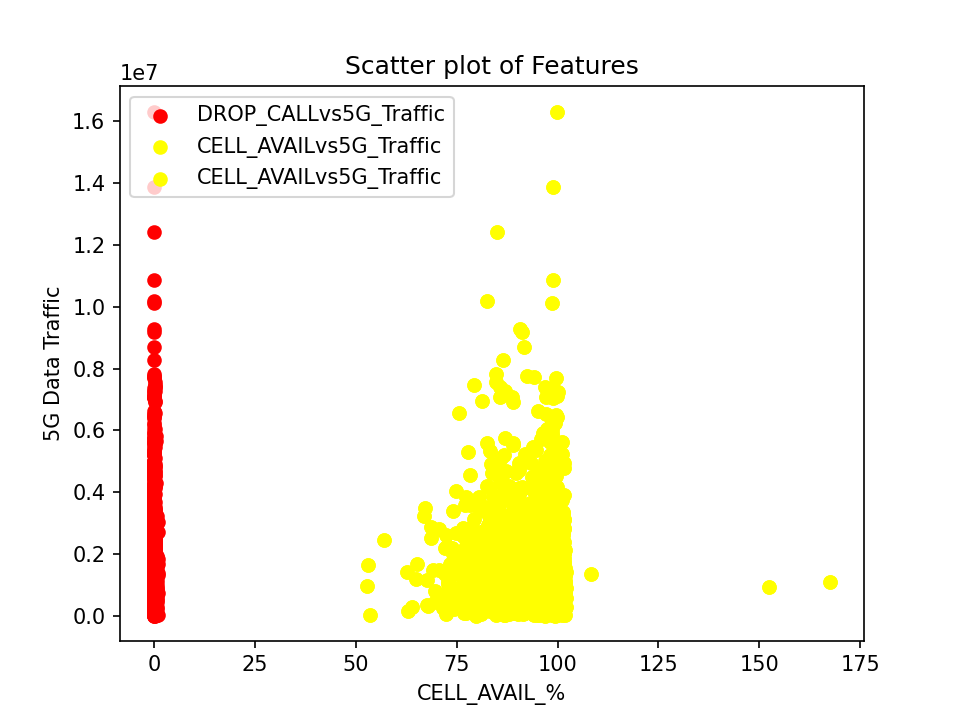

In [38]:
##Scatter Plot for the Noisy Dataset 
plt.scatter(features['avg_drops_all_calls_percentage'],features['5g_data_traffic'], label='DROP_CALLvs5G_Traffic', color='red')
            
plt.xlabel('Drop_all_call_%')
plt.ylabel('5G Data Traffic')
plt.title('Scatter plot of Features')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


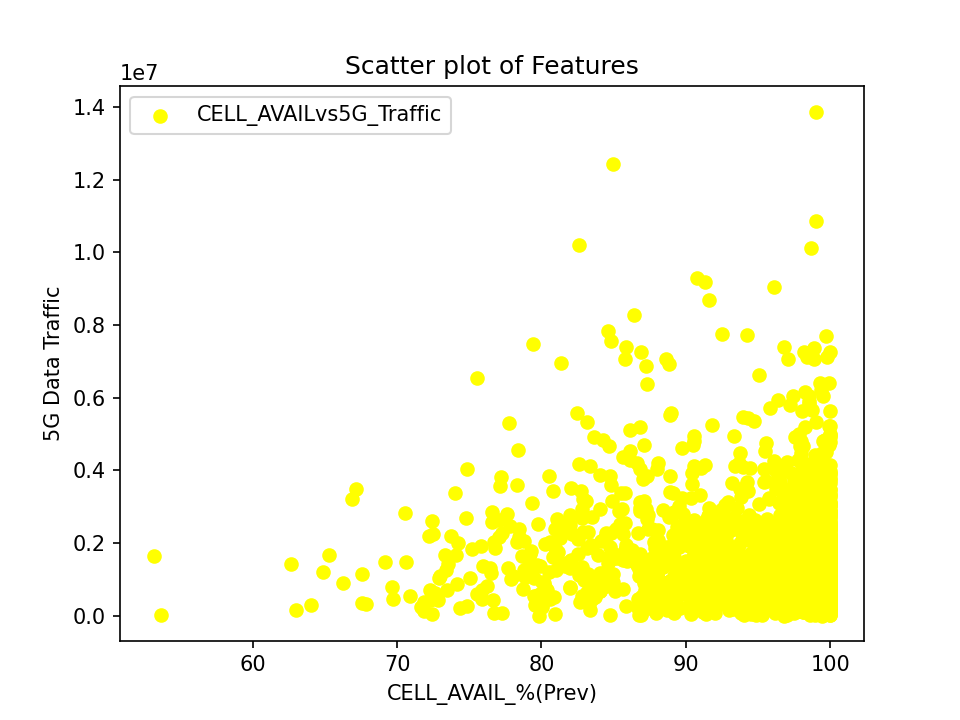

In [22]:
##Scatter Plot for the Noisy Dataset 
plt.scatter(df['avg_cell_availability_percentage'],df['5g_data_traffic'], label='CELL_AVAILvs5G_Traffic', color='yellow')
            
plt.xlabel('CELL_AVAIL_%(Prev)')
plt.ylabel('5G Data Traffic')
plt.title('Scatter plot of Features')
plt.legend()
plt.show()


In [19]:
df['avg_cell_availability_percentage']=df['avg_cell_availability_percentage'].apply(lambda x: 100 if x > 100 else x)

<IPython.core.display.Javascript object>


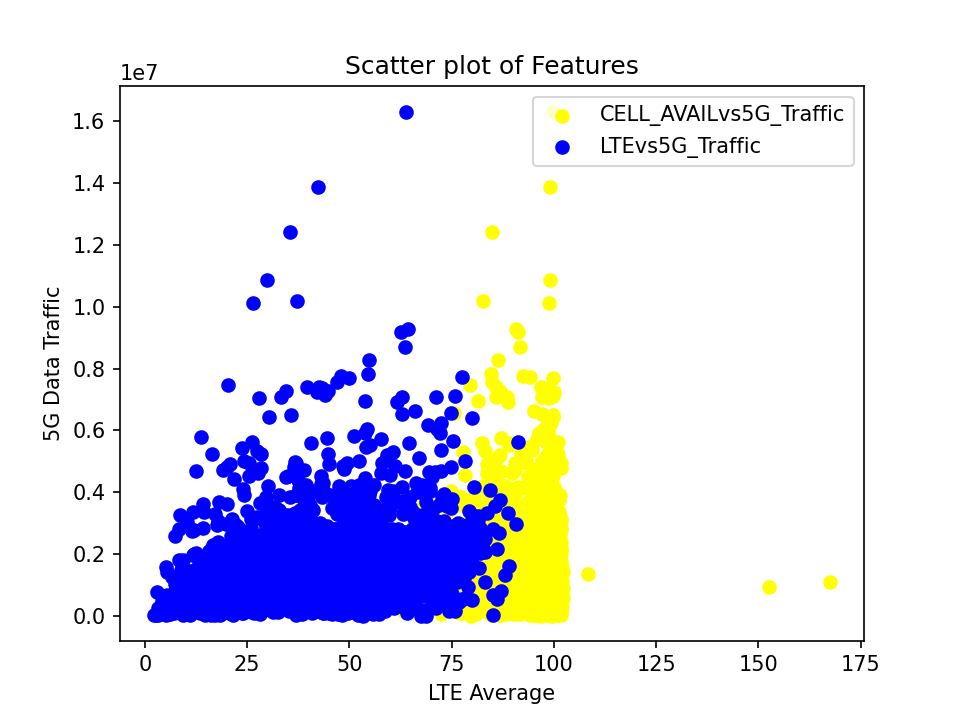

In [46]:
##Scatter Plot for the Noisy Dataset 
plt.scatter(features['avg_cell_availability_percentage'],features['5g_data_traffic'], label='CELL_AVAILvs5G_Traffic', color='yellow')
            
plt.xlabel('CELL_AVAIL_%')
plt.ylabel('5G Data Traffic')
plt.title('Scatter plot of Features')
plt.legend()
plt.show()


In [16]:
##Scatter Plot for the Noisy Dataset 
plt.scatter(features['avg_session_drop_percentage'],features['5g_data_traffic'], label='SESSION_DROPvs5G_Traffic', color='black')
            
plt.xlabel('SESSION_DROP_%')
plt.ylabel('5G Data Traffic')
plt.title('Scatter plot of Features')
plt.legend()
plt.show()


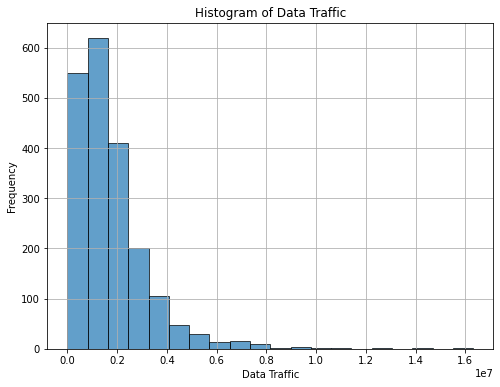

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
plt.hist(df['5g_data_traffic'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Data Traffic')
plt.ylabel('Frequency')
plt.title('Histogram of Data Traffic')
plt.grid(True)
plt.show()

In [16]:
def categorize_decision( data_traffic):
    if data_traffic >=1400000:
        return "Excellent Site"    ## Excellent Decision 
    #elif 1000000< data_traffic <=2000000:
    #    return "Average Site"
    else:
        return "Poor Site"    ## Poor Decision 

# Apply the function to create the new column
df['output_decision'] = df['5g_data_traffic'].apply(categorize_decision)

df.head()

,5g_data_traffic,avg_lte,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session,avg_drops_all_calls_percentage,avg_total_calls,avg_total_drop_calls,...,avg_csum_cell_availability_seconds,avg_sum_max_available_seconds,avg_session_drop_per_mb,avg_session_drop_percentage,avg_total_data_volume_mb,avg_total_session_drop,avg_avg_count_cells,avg_thruput,avg_4g_data_traffic,output_decision
0,1.859652e+06,60.921170,22.184733,37.222700,2.698878,3.685781e-02,1.559454,0.253806,4721.883908,12.052874,...,720129.955060,7.776000e+05,0.012056,0.443001,214900.318308,2566.555556,9.000000,5.973873,1.519077e+07,Excellent Site
1,7.032291e+05,28.452692,11.769903,45.666667,3.557225,0.000000e+00,0.629452,0.058075,3497.689247,2.081004,...,781605.778308,7.776000e+05,0.005170,0.119648,138538.758219,681.905018,9.000000,10.477647,8.617555e+06,Poor Site
2,4.746705e+05,56.766966,29.934487,48.922111,3.881602,5.933724e+07,1.513511,0.103581,5956.806247,6.163031,...,895189.339862,9.392516e+05,0.000116,0.012828,437232.924660,47.832744,10.870968,13.065869,1.130143e+07,Poor Site
3,1.637384e+06,31.591847,14.048151,41.014584,3.086846,4.344604e+07,1.040333,0.055482,4802.762007,2.822581,...,777592.956989,7.776000e+05,0.000039,0.003256,237924.629577,9.094265,9.000000,15.917387,1.790576e+07,Excellent Site
4,1.484324e+06,65.300042,28.291274,43.698347,3.357365,9.402577e-02,0.831326,0.083439,4995.089359,4.225065,...,893634.593607,1.025652e+06,0.002318,0.111834,626150.525479,1451.865406,11.870968,12.958015,3.305310e+07,Excellent Site


In [17]:
df=df.dropna(subset=['output_decision'])
df=df[df['output_decision'] != 'None']

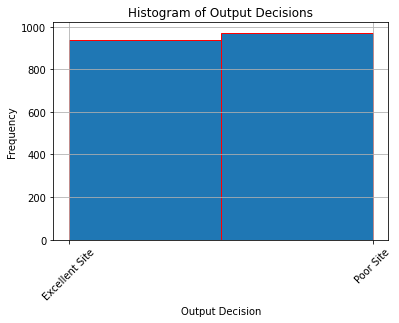

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(df['output_decision'], bins=2, edgecolor='red')
plt.xlabel('Output Decision')
plt.ylabel('Frequency')
plt.title('Histogram of Output Decisions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.tight_layout()

In [19]:
df.drop('5g_data_traffic', axis=1, inplace=True)

In [20]:
columns_except_output_decision=[col for col in df.columns if col != "output_decision"]
print(columns_except_output_decision)

['avg_lte', 'avg_prbs', 'avg_avail_prbs', 'avg_ngbr', 'avg_volte', 'avg_volte_session', 'avg_drops_all_calls_percentage', 'avg_total_calls', 'avg_total_drop_calls', 'avg_total_erlang_voice', 'avg_voice_call_drops_per_erlang', 'avg_cell_availability_percentage', 'avg_csum_cell_availability_seconds', 'avg_sum_max_available_seconds', 'avg_session_drop_per_mb', 'avg_session_drop_percentage', 'avg_total_data_volume_mb', 'avg_total_session_drop', 'avg_avg_count_cells', 'avg_thruput', 'avg_4g_data_traffic']


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
X=df[columns_except_output_decision]
y=df['output_decision']
train_data, test_data, train_labels, test_labels = train_test_split(X,y,
    test_size=0.2, random_state=42  
)

NameError: name 'columns_except_output_decision' is not defined

In [23]:
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1527, 21)
Test data shape: (382, 21)


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
cv_scores=cross_val_score(clf,X_train,y_train,cv=5,scoring='accuracy')
print("Cross-Validation Scores:",cv_scores)
print("Average Accuracy: ",cv_scores.mean())

Cross-Validation Scores: [0.70915033 0.69281046 0.67540984 0.66229508 0.67868852]
Average Accuracy:  0.6836708453873352


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have a DataFrame with features (X) and target variable (y)
# X should contain columns_except_output_decision

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_accuracy = 0.0
best_k = None

# Iterate over different values of k
for k in range(1, len(X.columns) + 1):
    # Initialize SelectKBest with the f_classif scoring function
    k_best = SelectKBest(score_func=f_classif, k=k)

    # Fit and transform the training data to select the best features
    X_train_selected = k_best.fit_transform(X_train, y_train)

    # Transform the test data based on the selected features
    X_test_selected = k_best.transform(X_test)

    # Initialize a simple classifier (Random Forest in this example)
    clf = RandomForestClassifier(random_state=42)

    # Fit the classifier on the training data with selected features
    clf.fit(X_train_selected, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test_selected)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Check if this k resulted in a better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        best_selected_features=X.columns[k_best.get_support(indices=True)].tolist()

print(f"Best k: {best_k}")
print(f"Best_features_names: {best_selected_features}")
print(f"Highest accuracy: {best_accuracy:.2f}")

Best k: 13
Best_features_names: ['avg_lte', 'avg_prbs', 'avg_avail_prbs', 'avg_volte', 'avg_volte_session', 'avg_total_calls', 'avg_total_erlang_voice', 'avg_csum_cell_availability_seconds', 'avg_sum_max_available_seconds', 'avg_total_data_volume_mb', 'avg_avg_count_cells', 'avg_thruput', 'avg_4g_data_traffic']
Highest accuracy: 0.72


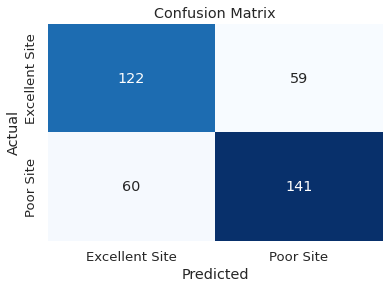

In [26]:
cm=confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # Adjust the font size

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Excellent Site', 'Poor Site'],
            yticklabels=['Excellent Site', 'Poor Site'])

# Add labels and a title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [27]:
report=classification_report(y_test,y_pred)
print(report)

                precision    recall  f1-score   support

Excellent Site       0.67      0.67      0.67       181
     Poor Site       0.70      0.70      0.70       201

      accuracy                           0.69       382
     macro avg       0.69      0.69      0.69       382
  weighted avg       0.69      0.69      0.69       382



In [28]:
coefficients=pd.Series(clf.feature_importances_,index=X.columns)

In [29]:
print(coefficients)

avg_lte                               0.045346
avg_prbs                              0.052864
avg_avail_prbs                        0.040818
avg_ngbr                              0.047004
avg_volte                             0.066867
avg_volte_session                     0.069342
avg_drops_all_calls_percentage        0.055115
avg_total_calls                       0.059329
avg_total_drop_calls                  0.039297
avg_total_erlang_voice                0.059646
avg_voice_call_drops_per_erlang       0.049150
avg_cell_availability_percentage      0.048253
avg_csum_cell_availability_seconds    0.051910
avg_sum_max_available_seconds         0.013761
avg_session_drop_per_mb               0.043998
avg_session_drop_percentage           0.047661
avg_total_data_volume_mb              0.048955
avg_total_session_drop                0.046108
avg_avg_count_cells                   0.016672
avg_thruput                           0.049886
avg_4g_data_traffic                   0.048019
dtype: float6

In [30]:
def categorize_decision( data_traffic):
    if data_traffic >=1400000:
        return "Excellent Site"    ## Excellent Decision  
    else:
        return "Poor Site"    ## Poor Decision 

# Apply the function to create the new column
random_rows['output_decision'] = random_rows['5g_data_traffic'].apply(categorize_decision)

random_rows.head()

,5g_data_traffic,avg_lte,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session,avg_drops_all_calls_percentage,avg_total_calls,avg_total_drop_calls,...,avg_csum_cell_availability_seconds,avg_sum_max_available_seconds,avg_session_drop_per_mb,avg_session_drop_percentage,avg_total_data_volume_mb,avg_total_session_drop,avg_avg_count_cells,avg_thruput,avg_4g_data_traffic,output_decision
1916,2743920.3659950000000,11.531578747733330000,5.270943098733330000,45.474910394266670000,3.541884329333330000,0.012891586700000000,0.373780672766670000,0.16197800000000,1868.286507936533330000,1.948873527933330000,...,877864.349146883300000000,1.036800e+06,0.00347122866670000,0.07819124700000000,75102.51979588600000000,236.643958013300000000,12.000000,8.778930191400000000,2220831.0738586670000,Excellent Site
785,593519.9042678000000,31.483751443866670000,16.808639546000000000,49.522491039400000000,3.948354610766670000,11057484.227479092000000000,0.271779433033330000,0.07882266670000,2320.210344827600000000,1.734482758633330000,...,1020443.507662835233330000,1.036800e+06,0.00003254533330000,0.00403413800000000,271851.88642696066670000,8.813409961666670000,12.000000,14.362884303466670000,8431845.1784543330000,Poor Site
75,1038834.0253392860000,30.873452874866670000,15.436726437433330000,50.000000000000000000,3.981961780166670000,44960124.659438470733330000,1.202547988133330000,0.03353600000000,4169.484229390666670000,1.376702508933330000,...,527757.611111111100000000,5.184000e+05,0.00003308400000000,0.00234261633330000,210784.66803745300000000,6.850896057366670000,6.000000,22.476866479000000000,14307101.5894710000000,Poor Site
1694,533646.1729986670000,48.961408942000000000,19.360052606433330000,36.007805325966670000,2.566328534066670000,1.318708447733330000,2.296799900500000000,0.15071533330000,10297.867895545333330000,16.490783410133330000,...,786617.641676469833330000,9.392516e+05,0.00824734533330000,0.31732235033330000,283359.63331274833330000,2173.991167434733330000,10.870968,6.597970236866670000,6449364.1234153330000,Poor Site
650,1211286.0848336670000,61.321605809833330000,26.393596278866670000,42.236467236500000000,3.212073721000000000,0.015132438433330000,0.771533508966670000,0.05934400000000,6257.713409961666670000,3.873822766033330000,...,772815.282246307133330000,8.409600e+05,0.00118654800000000,0.06601211366670000,577259.66733717566670000,679.056890372033330000,9.733333,13.194635529766670000,26805518.3178736670000,Poor Site


In [31]:
random_rows.drop('5g_data_traffic', axis=1, inplace=True)

In [32]:
columns_except_output_decision=[col for col in random_rows.columns if col != "output_decision"]
print(columns_except_output_decision)

['avg_lte', 'avg_prbs', 'avg_avail_prbs', 'avg_ngbr', 'avg_volte', 'avg_volte_session', 'avg_drops_all_calls_percentage', 'avg_total_calls', 'avg_total_drop_calls', 'avg_total_erlang_voice', 'avg_voice_call_drops_per_erlang', 'avg_cell_availability_percentage', 'avg_csum_cell_availability_seconds', 'avg_sum_max_available_seconds', 'avg_session_drop_per_mb', 'avg_session_drop_percentage', 'avg_total_data_volume_mb', 'avg_total_session_drop', 'avg_avg_count_cells', 'avg_thruput', 'avg_4g_data_traffic']


In [33]:
val=random_rows[columns_except_output_decision]

In [34]:
val_y=random_rows['output_decision']

In [35]:
y_pred = clf.predict(val)

In [36]:
accuracy = accuracy_score(val_y, y_pred)

In [37]:
print(accuracy)

0.72


In [38]:
predictions_df=pd.DataFrame({
    'Predicted_outcome':y_pred
})

In [39]:
predictions_df.head()

,Predicted_outcome
0,Poor Site
1,Poor Site
2,Poor Site
3,Poor Site
4,Excellent Site


In [40]:
result_df=pd.merge(random_rows,predictions_df,left_index=True,right_index=True)

In [41]:
result_df.head()

,avg_lte,avg_prbs,avg_avail_prbs,avg_ngbr,avg_volte,avg_volte_session,avg_drops_all_calls_percentage,avg_total_calls,avg_total_drop_calls,avg_total_erlang_voice,...,avg_sum_max_available_seconds,avg_session_drop_per_mb,avg_session_drop_percentage,avg_total_data_volume_mb,avg_total_session_drop,avg_avg_count_cells,avg_thruput,avg_4g_data_traffic,output_decision,Predicted_outcome
75,30.873452874866670000,15.436726437433330000,50.000000000000000000,3.981961780166670000,44960124.659438470733330000,1.202547988133330000,0.03353600000000,4169.484229390666670000,1.376702508933330000,119.796347271966670000,...,518400.0,0.00003308400000000,0.00234261633330000,210784.66803745300000000,6.850896057366670000,6.0,22.476866479000000000,14307101.5894710000000,Poor Site,Poor Site
23,3.381481517333330000,1.389852330766670000,43.678648086333330000,3.367097046400000000,2342105.160499320233330000,0.051184147300000000,0.04328233330000,228.356989247300000000,0.088172043000000000,8.490353534466670000,...,1036800.0,0.00019342933330000,0.00689842300000000,6844.68636007233330000,1.159856630833330000,12.0,17.479440405300000000,207993.6322923330000,Poor Site,Excellent Site
27,39.911546875333330000,17.474643406500000000,40.873095878133330000,3.072225118333330000,52056606.290023894866670000,1.283409077133330000,0.06553300000000,4913.373476702500000000,3.108243727600000000,169.755041348066670000,...,777600.0,0.00006783666670000,0.00550071700000000,310859.99119605066670000,21.577060931900000000,9.0,13.311880422566670000,20281553.7229793330000,Excellent Site,Excellent Site
